In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [4]:
from elitho.mask_pattern import LinePattern
from elitho import const
from elitho import fourier

mask = LinePattern(cd=56, gap=80, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

In [5]:
type(mask)

numpy.ndarray

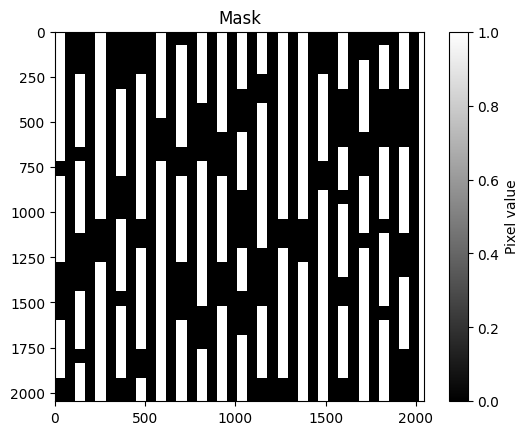

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [27]:
%%timeit -n 10
# cpu ver
ampta = 0.95 + 0.0j
ampvc = 1.0 + 0.0j
famp = fourier.mask(mask, ampta, ampvc)

165 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%%timeit -n 10
# cpu ver
_, _, _, _ = fourier.coefficients(mask)

449 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
import cupy as cp
cp_mask = cp.array(mask)

In [30]:
%%timeit -n 10
# gpu
ampta = 0.95 + 0.0j
ampvc = 1.0 + 0.0j
famp = fourier.mask(cp_mask, ampta, ampvc)

8.67 ms ± 147 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit -n 10
_, _, _, _ = fourier.coefficients(cp_mask)

28.5 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
rfamp.shape, const.Mrange2

((301, 301), 301)

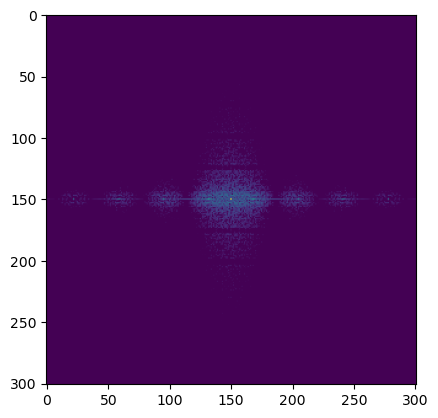

In [45]:
plt.imshow(rfamp)
plt.show()

In [31]:
def test_np_ver(pattern_mask: np.ndarray, ampta: complex, ampvc: complex): 
    meshX = const.FDIVX // const.NDIVX
    meshY = const.FDIVY // const.NDIVY

    pattern = np.where(
        np.kron(pattern_mask, np.ones((meshX, meshY))), ampta, ampvc
    ).astype(
        np.complex128
    )  # shape: (FDIVX, FDIVY)

    famp_full = np.fft.fftshift(np.fft.fft2(pattern)) / (const.FDIVX * const.FDIVY)

    # === 3. 周波数中心付近の領域を切り出す ===
    cx = const.FDIVX // 2
    cy = const.FDIVY // 2
    half_L = const.Lrange2 // 2
    half_M = const.Mrange2 // 2

    famp = famp_full[
        cx - half_L : cx + half_L + (const.Lrange2 % 2),
        cy - half_M : cy + half_M + (const.Mrange2 % 2)
    ]
    
    return famp

In [32]:
own_famp = test_np_ver(mask, ampta, ampvc)
own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)

/tmp/ipykernel_418129/3198047890.py:2: RuntimeWarning: divide by zero encountered in log
  own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)


In [33]:
own_rfamp.shape

(301, 301)

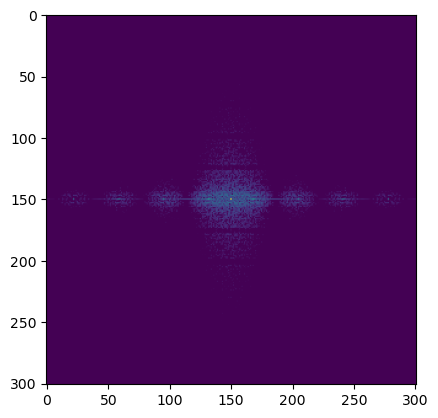

In [34]:
plt.imshow(own_rfamp)
plt.show()

In [42]:
np.allclose(rfamp, own_rfamp, atol=1e-6, rtol=1e-4)

True